# 🚀 Análisis de Variables para Modelo de Predicción de Tiempo

## Objetivo
Analizar las variables del archivo `1000registros.json` para determinar cuáles son útiles para predecir el **tiempo de respuesta** del usuario en cada pregunta. 

El objetivo es implementar un **modo infinito adaptativo** donde:
- Si el usuario **responde lento** → se le da **más tiempo** en la siguiente pregunta
- Si el usuario **responde rápido** → se le da **menos tiempo** en la siguiente pregunta

In [5]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 1. Cargar y Explorar los Datos

In [6]:
# Cargar datos desde JSON
with open('1000registros.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convertir a DataFrame
df = pd.DataFrame(data)

print(f"📊 Total de registros: {len(df)}")
print(f"📋 Columnas disponibles: {df.columns.tolist()}")
print("\n" + "="*60)
df.head(10)

📊 Total de registros: 1000
📋 Columnas disponibles: ['nivel_actual', 'vidas_actuales', 'puntaje_actual', 'respuestas_correctas_acumuladas', 'tiempo_respuesta_pregunta', 'numero_1', 'numero_2', 'signo_operacional', 'resultado_operacional']



,nivel_actual,vidas_actuales,puntaje_actual,respuestas_correctas_acumuladas,tiempo_respuesta_pregunta,numero_1,numero_2,signo_operacional,resultado_operacional
0,1,5,10,1,3.616667,10,10,/,1
1,1,5,20,2,1.333333,8,2,+,10
2,1,5,30,3,2.150000,2,6,+,8
3,2,5,40,4,1.716667,39,23,+,62
4,2,5,35,4,1.850000,47,13,+,60
5,2,4,30,4,3.116667,7,6,*,42
6,2,3,40,5,2.883333,2,9,*,18
7,2,3,35,5,0.983333,9,4,*,36
8,2,2,45,6,1.866667,36,36,+,72
9,2,2,55,7,2.716667,5,5,/,1


In [7]:
# Información del DataFrame
print("📈 Información del Dataset:")
print("="*60)
df.info()
print("\n" + "="*60)
print("\n📊 Estadísticas Descriptivas:")
df.describe()

📈 Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   nivel_actual                     1000 non-null   int64  
 1   vidas_actuales                   1000 non-null   int64  
 2   puntaje_actual                   1000 non-null   int64  
 3   respuestas_correctas_acumuladas  1000 non-null   int64  
 4   tiempo_respuesta_pregunta        1000 non-null   float64
 5   numero_1                         1000 non-null   int64  
 6   numero_2                         1000 non-null   int64  
 7   signo_operacional                1000 non-null   object 
 8   resultado_operacional            1000 non-null   int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 70.4+ KB


📊 Estadísticas Descriptivas:


,nivel_actual,vidas_actuales,puntaje_actual,respuestas_correctas_acumuladas,tiempo_respuesta_pregunta,numero_1,numero_2,resultado_operacional
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.0000,1000.000000
mean,2.296000,2.525000,75.155000,8.60500,2.335250,33.107000,18.5400,30.228000
std,0.763523,1.253374,49.347605,5.38163,0.943453,26.526425,24.4626,35.115711
min,1.000000,1.000000,0.000000,0.00000,0.833333,2.000000,1.0000,0.000000
25%,2.000000,2.000000,30.000000,4.00000,1.683333,9.000000,5.0000,7.000000
50%,2.000000,2.000000,70.000000,8.00000,2.283333,32.000000,8.0000,12.000000
75%,3.000000,3.000000,120.000000,13.00000,2.900000,48.000000,23.0000,56.000000
max,3.000000,5.000000,170.000000,19.00000,5.400000,98.000000,98.0000,132.000000


## 2. Análisis de las Variables Disponibles

### Variables del Dataset:

| Variable | Descripción | Tipo |
|----------|-------------|------|
| `nivel_actual` | Nivel del juego (1, 2, o 3) | Categórica/Ordinal |
| `vidas_actuales` | Cantidad de vidas del jugador | Numérica |
| `puntaje_actual` | Puntuación acumulada | Numérica |
| `respuestas_correctas_acumuladas` | Total de respuestas correctas | Numérica |
| `tiempo_respuesta_pregunta` | ⭐ **VARIABLE OBJETIVO** - Tiempo en responder | Numérica |
| `numero_1` | Primer número del problema | Numérica |
| `numero_2` | Segundo número del problema | Numérica |
| `signo_operacional` | Operación (+, -, *, /) | Categórica |
| `resultado_operacional` | Resultado de la operación | Numérica |

In [8]:
# Verificar valores únicos de variables categóricas
print("🔢 Niveles únicos:", df['nivel_actual'].unique())
print("➗ Signos operacionales únicos:", df['signo_operacional'].unique())
print("\n❤️ Distribución de vidas:")
print(df['vidas_actuales'].value_counts().sort_index())

🔢 Niveles únicos: [1 2 3]
➗ Signos operacionales únicos: ['/' '+' '*' '-']

❤️ Distribución de vidas:
vidas_actuales
1    161
2    509
3    117
4     70
5    143
Name: count, dtype: int64


## 3. Análisis de la Variable Objetivo: `tiempo_respuesta_pregunta`

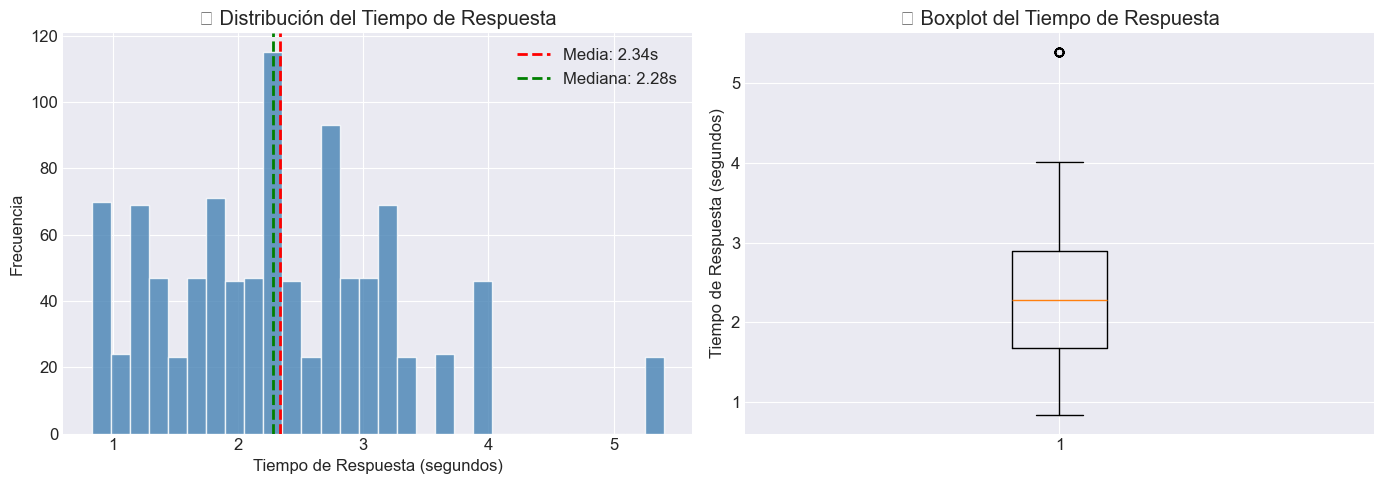


⏱️ Estadísticas del Tiempo de Respuesta:
   Mínimo: 0.83 segundos
   Máximo: 5.40 segundos
   Media: 2.34 segundos
   Mediana: 2.28 segundos
   Desv. Estándar: 0.94 segundos


In [9]:
# Distribución del tiempo de respuesta
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df['tiempo_respuesta_pregunta'], bins=30, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(df['tiempo_respuesta_pregunta'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["tiempo_respuesta_pregunta"].mean():.2f}s')
axes[0].axvline(df['tiempo_respuesta_pregunta'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df["tiempo_respuesta_pregunta"].median():.2f}s')
axes[0].set_xlabel('Tiempo de Respuesta (segundos)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('📊 Distribución del Tiempo de Respuesta')
axes[0].legend()

# Boxplot
axes[1].boxplot(df['tiempo_respuesta_pregunta'], vert=True)
axes[1].set_ylabel('Tiempo de Respuesta (segundos)')
axes[1].set_title('📦 Boxplot del Tiempo de Respuesta')

plt.tight_layout()
plt.show()

print(f"\n⏱️ Estadísticas del Tiempo de Respuesta:")
print(f"   Mínimo: {df['tiempo_respuesta_pregunta'].min():.2f} segundos")
print(f"   Máximo: {df['tiempo_respuesta_pregunta'].max():.2f} segundos")
print(f"   Media: {df['tiempo_respuesta_pregunta'].mean():.2f} segundos")
print(f"   Mediana: {df['tiempo_respuesta_pregunta'].median():.2f} segundos")
print(f"   Desv. Estándar: {df['tiempo_respuesta_pregunta'].std():.2f} segundos")

## 4. Análisis de Correlaciones

Vamos a analizar qué variables tienen mayor correlación con el tiempo de respuesta.

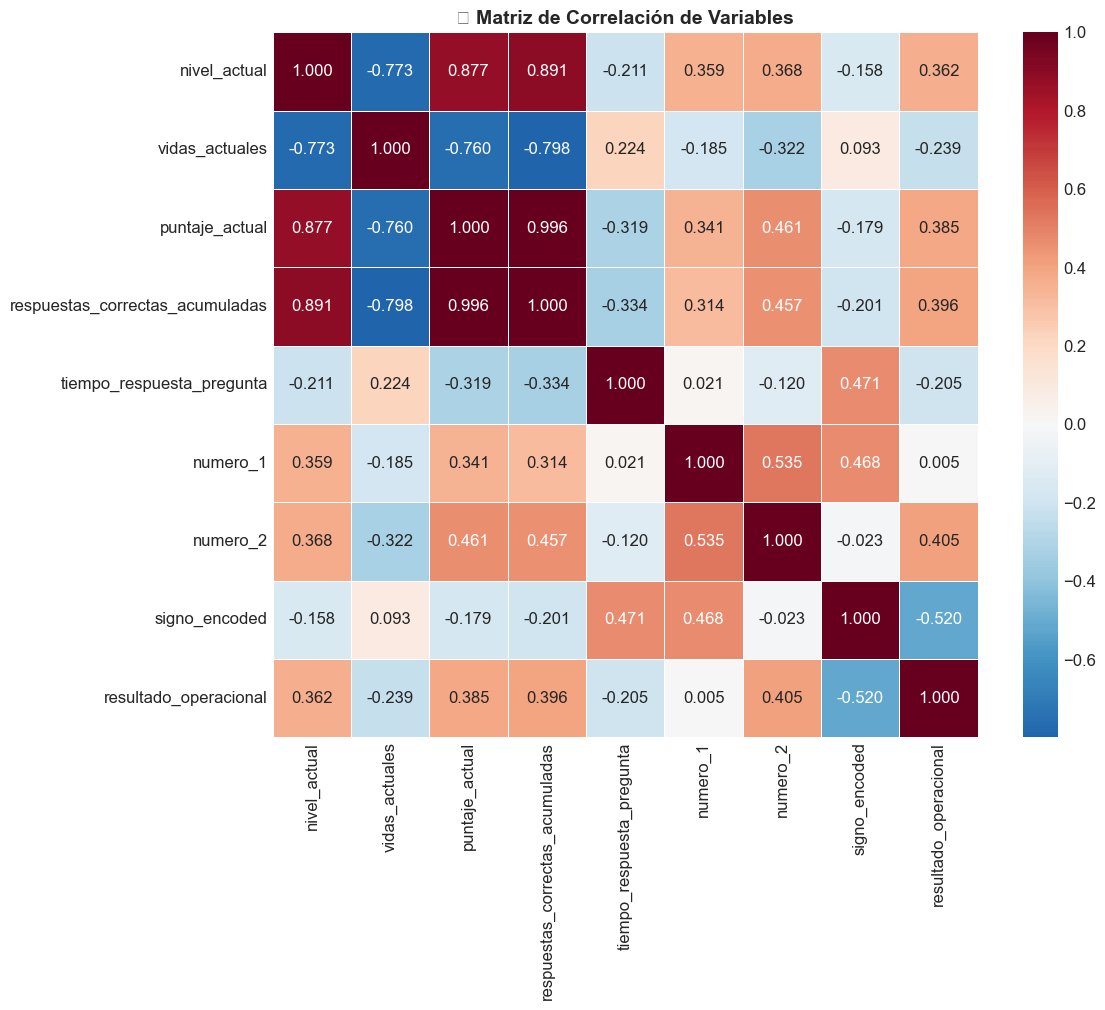

In [10]:
# Crear copia para análisis con codificación de variables categóricas
df_analysis = df.copy()

# Codificar el signo operacional
le = LabelEncoder()
df_analysis['signo_encoded'] = le.fit_transform(df_analysis['signo_operacional'])

# Calcular matriz de correlación
numeric_cols = ['nivel_actual', 'vidas_actuales', 'puntaje_actual', 
                'respuestas_correctas_acumuladas', 'tiempo_respuesta_pregunta',
                'numero_1', 'numero_2', 'signo_encoded', 'resultado_operacional']

correlation_matrix = df_analysis[numeric_cols].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', linewidths=0.5, square=True)
plt.title('🔗 Matriz de Correlación de Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

📊 CORRELACIONES CON TIEMPO DE RESPUESTA:
signo_encoded                            = +0.4710 (+) 🟢 FUERTE
respuestas_correctas_acumuladas          = -0.3345 (-) 🟢 FUERTE
puntaje_actual                           = -0.3186 (-) 🟢 FUERTE
vidas_actuales                           = +0.2238 (+) 🟡 MODERADA
nivel_actual                             = -0.2108 (-) 🟡 MODERADA
resultado_operacional                    = -0.2045 (-) 🟡 MODERADA
numero_2                                 = -0.1204 (-) 🟡 MODERADA
numero_1                                 = +0.0214 (+) 🔴 DÉBIL


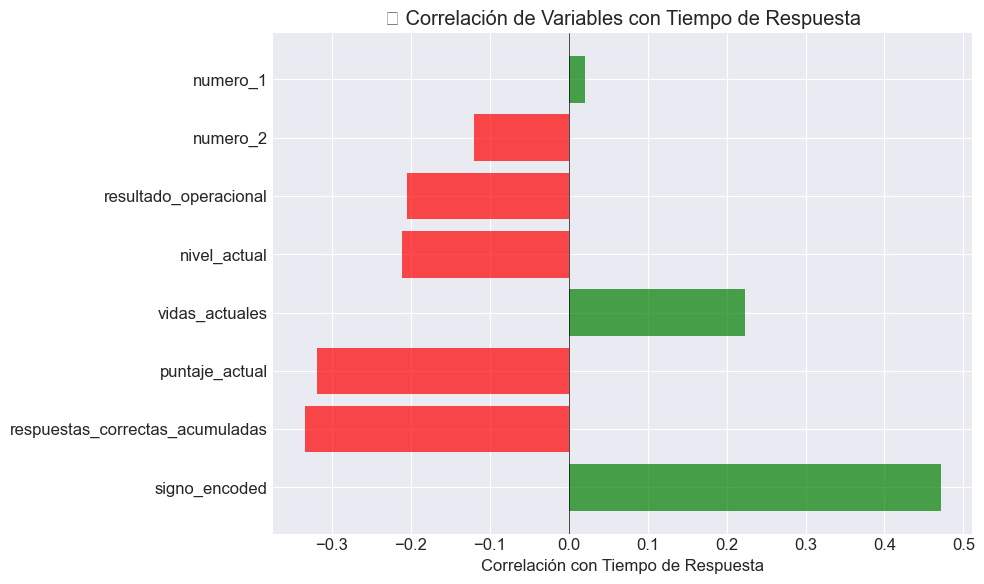

In [11]:
# Correlaciones específicas con tiempo de respuesta
correlations_with_time = correlation_matrix['tiempo_respuesta_pregunta'].drop('tiempo_respuesta_pregunta').sort_values(key=abs, ascending=False)

print("📊 CORRELACIONES CON TIEMPO DE RESPUESTA:")
print("="*50)
for var, corr in correlations_with_time.items():
    strength = "🟢 FUERTE" if abs(corr) > 0.3 else "🟡 MODERADA" if abs(corr) > 0.1 else "🔴 DÉBIL"
    direction = "(+)" if corr > 0 else "(-)"
    print(f"{var:40} = {corr:+.4f} {direction} {strength}")

# Gráfico de barras de correlaciones
plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in correlations_with_time.values]
plt.barh(correlations_with_time.index, correlations_with_time.values, color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.xlabel('Correlación con Tiempo de Respuesta')
plt.title('📊 Correlación de Variables con Tiempo de Respuesta')
plt.tight_layout()
plt.show()

## 5. Análisis del Tiempo por Tipo de Operación

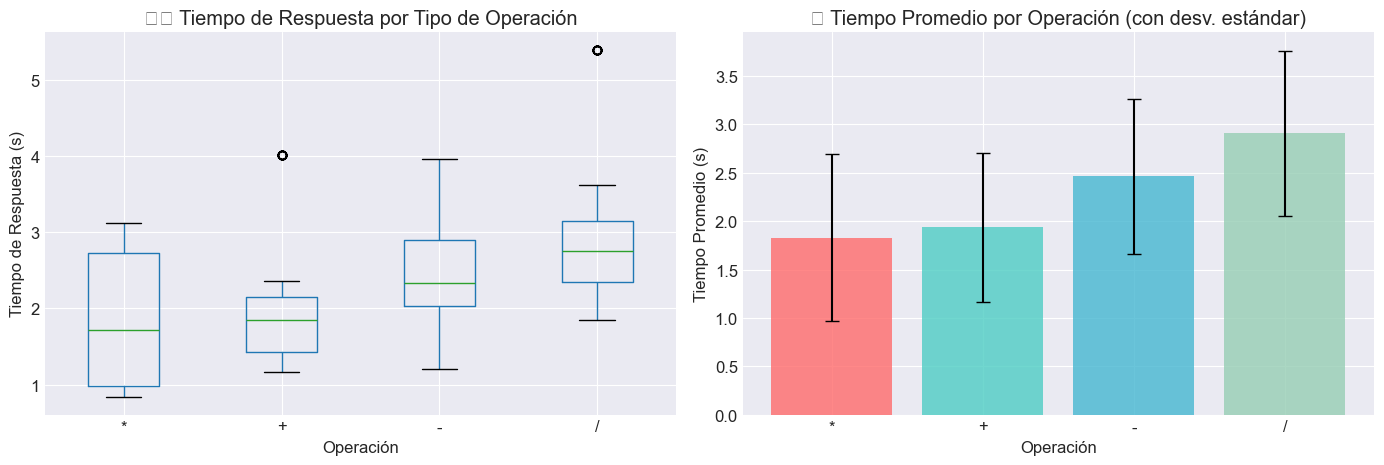


📋 Estadísticas por Tipo de Operación:
                   Media  Desv.Std  Cantidad
signo_operacional                           
*                  1.830     0.867       234
+                  1.935     0.771       235
-                  2.463     0.798       207
/                  2.909     0.856       324


In [12]:
# Tiempo de respuesta por tipo de operación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot por operación
df.boxplot(column='tiempo_respuesta_pregunta', by='signo_operacional', ax=axes[0])
axes[0].set_xlabel('Operación')
axes[0].set_ylabel('Tiempo de Respuesta (s)')
axes[0].set_title('⏱️ Tiempo de Respuesta por Tipo de Operación')
plt.suptitle('')  # Eliminar el título automático

# Estadísticas por operación
operation_stats = df.groupby('signo_operacional')['tiempo_respuesta_pregunta'].agg(['mean', 'std', 'count'])
operation_stats.columns = ['Media', 'Desv.Std', 'Cantidad']

# Gráfico de barras
axes[1].bar(operation_stats.index, operation_stats['Media'], 
           yerr=operation_stats['Desv.Std'], capsize=5, 
           color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'], alpha=0.8)
axes[1].set_xlabel('Operación')
axes[1].set_ylabel('Tiempo Promedio (s)')
axes[1].set_title('📊 Tiempo Promedio por Operación (con desv. estándar)')

plt.tight_layout()
plt.show()

print("\n📋 Estadísticas por Tipo de Operación:")
print(operation_stats.round(3))

## 6. Análisis del Tiempo por Nivel del Juego

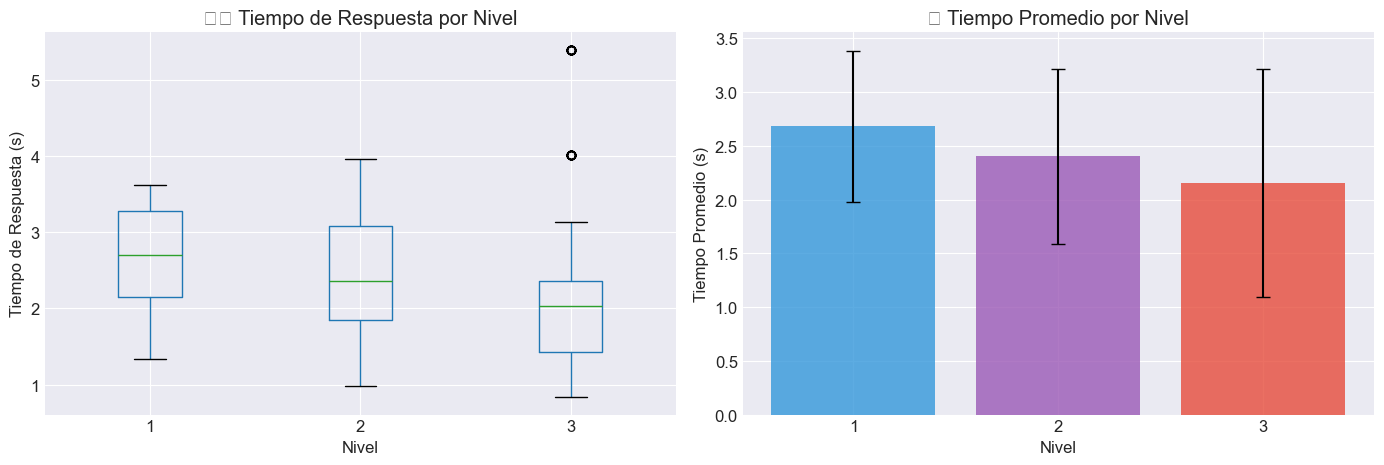


📋 Estadísticas por Nivel:
              Media  Desv.Std  Cantidad
nivel_actual                           
1             2.682     0.703       187
2             2.402     0.815       330
3             2.156     1.058       483


In [13]:
# Tiempo de respuesta por nivel
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot por nivel
df.boxplot(column='tiempo_respuesta_pregunta', by='nivel_actual', ax=axes[0])
axes[0].set_xlabel('Nivel')
axes[0].set_ylabel('Tiempo de Respuesta (s)')
axes[0].set_title('⏱️ Tiempo de Respuesta por Nivel')
plt.suptitle('')

# Estadísticas por nivel
level_stats = df.groupby('nivel_actual')['tiempo_respuesta_pregunta'].agg(['mean', 'std', 'count'])
level_stats.columns = ['Media', 'Desv.Std', 'Cantidad']

# Gráfico de barras
colors_level = ['#3498db', '#9b59b6', '#e74c3c']
axes[1].bar(level_stats.index, level_stats['Media'], 
           yerr=level_stats['Desv.Std'], capsize=5, 
           color=colors_level, alpha=0.8)
axes[1].set_xlabel('Nivel')
axes[1].set_ylabel('Tiempo Promedio (s)')
axes[1].set_title('📊 Tiempo Promedio por Nivel')
axes[1].set_xticks([1, 2, 3])

plt.tight_layout()
plt.show()

print("\n📋 Estadísticas por Nivel:")
print(level_stats.round(3))

## 7. Análisis de Complejidad de la Pregunta

Creamos variables derivadas que pueden indicar la dificultad de la pregunta.

In [14]:
# Crear variables de complejidad
df['magnitud_numeros'] = df['numero_1'] + df['numero_2']  # Suma total de los números
df['diferencia_numeros'] = abs(df['numero_1'] - df['numero_2'])  # Diferencia entre números
df['producto_numeros'] = df['numero_1'] * df['numero_2']  # Producto
df['max_numero'] = df[['numero_1', 'numero_2']].max(axis=1)  # Número máximo
df['min_numero'] = df[['numero_1', 'numero_2']].min(axis=1)  # Número mínimo
df['digitos_totales'] = df['numero_1'].apply(lambda x: len(str(x))) + df['numero_2'].apply(lambda x: len(str(x)))  # Total de dígitos

# Correlaciones de las nuevas variables con tiempo
new_vars = ['magnitud_numeros', 'diferencia_numeros', 'producto_numeros', 'max_numero', 'min_numero', 'digitos_totales']
correlations_new = df[new_vars + ['tiempo_respuesta_pregunta']].corr()['tiempo_respuesta_pregunta'].drop('tiempo_respuesta_pregunta')

print("📊 CORRELACIONES DE VARIABLES DE COMPLEJIDAD:")
print("="*50)
for var, corr in correlations_new.sort_values(key=abs, ascending=False).items():
    strength = "🟢 ÚTIL" if abs(corr) > 0.05 else "🔴 NO ÚTIL"
    print(f"{var:30} = {corr:+.4f} {strength}")

📊 CORRELACIONES DE VARIABLES DE COMPLEJIDAD:
diferencia_numeros             = +0.1483 🟢 ÚTIL
min_numero                     = -0.1358 🟢 ÚTIL
producto_numeros               = -0.1054 🟢 ÚTIL
magnitud_numeros               = -0.0532 🟢 ÚTIL
max_numero                     = +0.0113 🔴 NO ÚTIL
digitos_totales                = +0.0079 🔴 NO ÚTIL


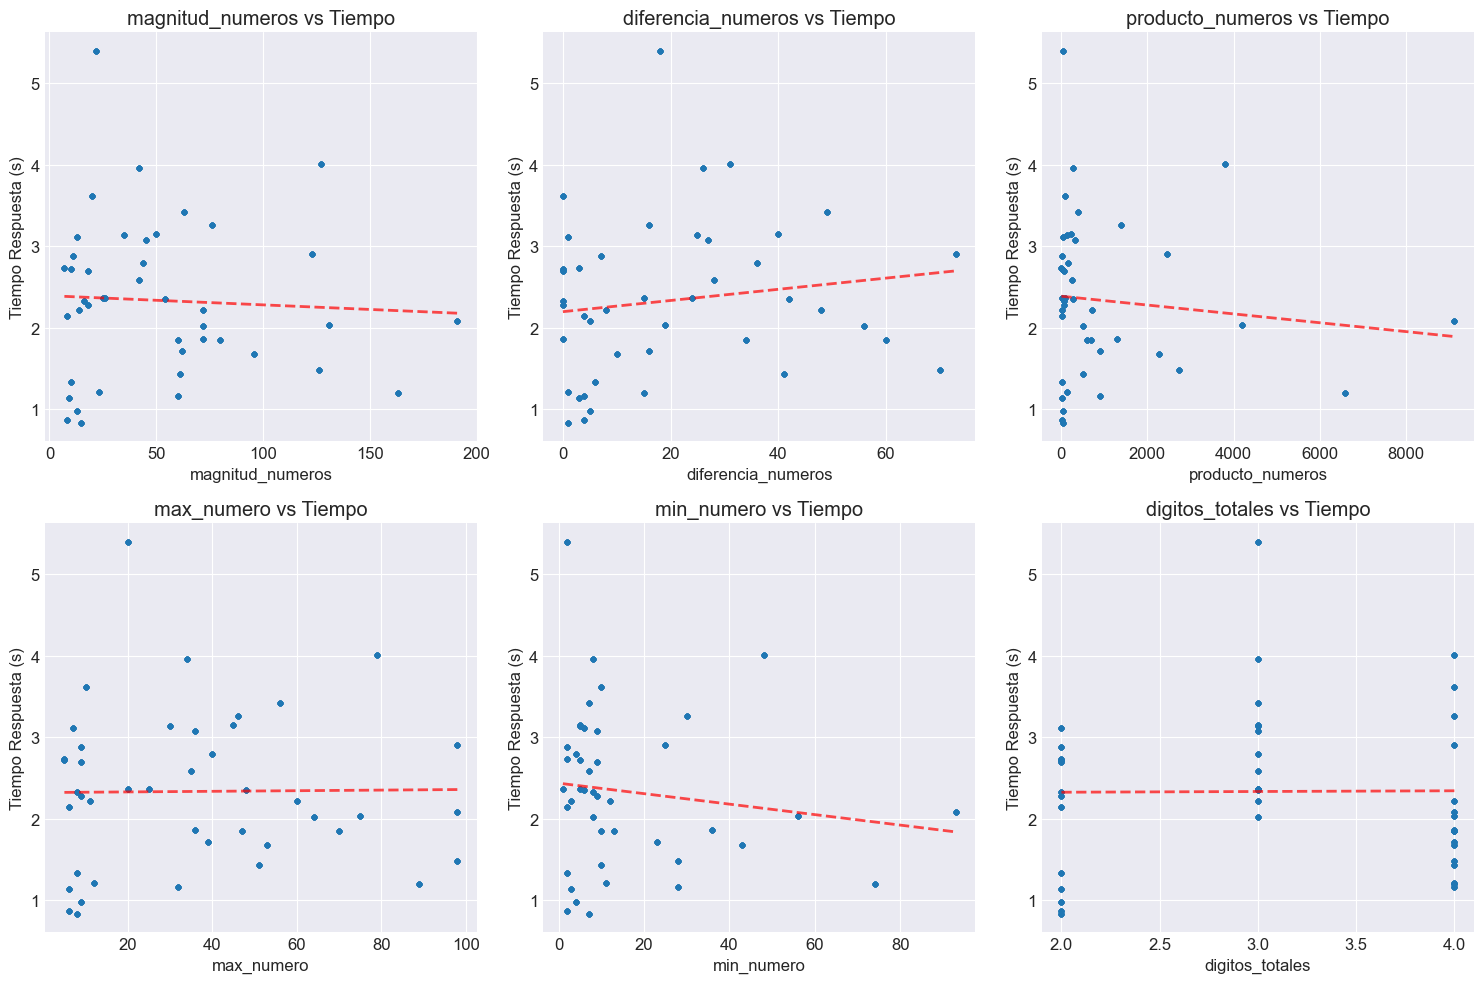

In [15]:
# Visualizar relaciones entre variables de complejidad y tiempo
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(new_vars):
    axes[i].scatter(df[var], df['tiempo_respuesta_pregunta'], alpha=0.3, s=10)
    # Línea de tendencia
    z = np.polyfit(df[var], df['tiempo_respuesta_pregunta'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[var].min(), df[var].max(), 100)
    axes[i].plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.7)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Tiempo Respuesta (s)')
    axes[i].set_title(f'{var} vs Tiempo')

plt.tight_layout()
plt.show()

## 8. Feature Engineering: Crear Variable del Tiempo Anterior

Para el modelo adaptativo, necesitamos considerar el **tiempo de respuesta de la pregunta anterior** como predictor.

In [16]:
# Crear variable lag (tiempo de respuesta anterior)
df['tiempo_respuesta_anterior'] = df['tiempo_respuesta_pregunta'].shift(1)

# También crear promedio móvil de últimas respuestas
df['tiempo_promedio_ultimas_3'] = df['tiempo_respuesta_pregunta'].rolling(window=3, min_periods=1).mean().shift(1)
df['tiempo_promedio_ultimas_5'] = df['tiempo_respuesta_pregunta'].rolling(window=5, min_periods=1).mean().shift(1)

# Tendencia de velocidad (¿está mejorando o empeorando?)
df['diferencia_tiempo_anterior'] = df['tiempo_respuesta_pregunta'].shift(1) - df['tiempo_respuesta_pregunta'].shift(2)

# Eliminar filas con NaN (primera fila)
df_model = df.dropna().copy()

print(f"📊 Registros disponibles para modelado: {len(df_model)}")

# Correlación de las nuevas variables secuenciales
seq_vars = ['tiempo_respuesta_anterior', 'tiempo_promedio_ultimas_3', 'tiempo_promedio_ultimas_5', 'diferencia_tiempo_anterior']
correlations_seq = df_model[seq_vars + ['tiempo_respuesta_pregunta']].corr()['tiempo_respuesta_pregunta'].drop('tiempo_respuesta_pregunta')

print("\n📊 CORRELACIONES DE VARIABLES SECUENCIALES:")
print("="*60)
for var, corr in correlations_seq.sort_values(key=abs, ascending=False).items():
    strength = "🟢 MUY ÚTIL" if abs(corr) > 0.3 else "🟡 ÚTIL" if abs(corr) > 0.1 else "🔴 DÉBIL"
    print(f"{var:40} = {corr:+.4f} {strength}")

📊 Registros disponibles para modelado: 998

📊 CORRELACIONES DE VARIABLES SECUENCIALES:
tiempo_promedio_ultimas_3                = +0.1943 🟡 ÚTIL
tiempo_respuesta_anterior                = +0.1824 🟡 ÚTIL
diferencia_tiempo_anterior               = +0.1558 🟡 ÚTIL
tiempo_promedio_ultimas_5                = +0.0697 🔴 DÉBIL


## 9. Resumen de Variables Útiles para el Modelo

In [17]:
# Seleccionar las mejores variables
print("\n" + "="*70)
print("🎯 RESUMEN: VARIABLES RECOMENDADAS PARA EL MODELO DE PREDICCIÓN")
print("="*70)

print("\n📌 VARIABLES MÁS RELEVANTES (ordenadas por importancia):")
print("-" * 70)

recommended_features = [
    ("tiempo_respuesta_anterior", "⭐⭐⭐", "Tiempo que tardó en la pregunta anterior"),
    ("tiempo_promedio_ultimas_3", "⭐⭐⭐", "Promedio de las últimas 3 respuestas"),
    ("signo_operacional", "⭐⭐", "Tipo de operación matemática"),
    ("nivel_actual", "⭐⭐", "Nivel del juego (afecta dificultad)"),
    ("numero_1", "⭐", "Primer número del problema"),
    ("numero_2", "⭐", "Segundo número del problema"),
    ("resultado_operacional", "⭐", "Resultado de la operación"),
    ("respuestas_correctas_acumuladas", "⭐", "Experiencia acumulada del jugador"),
]

for var, rating, description in recommended_features:
    print(f"  {rating} {var:40} - {description}")

print("\n📊 VARIABLES DERIVADAS ADICIONALES ÚTILES:")
print("-" * 70)
derived_features = [
    ("digitos_totales", "Suma de dígitos de ambos números"),
    ("magnitud_numeros", "Suma de ambos números"),
    ("max_numero", "El número más grande del problema"),
]

for var, description in derived_features:
    print(f"  ⭐ {var:40} - {description}")


🎯 RESUMEN: VARIABLES RECOMENDADAS PARA EL MODELO DE PREDICCIÓN

📌 VARIABLES MÁS RELEVANTES (ordenadas por importancia):
----------------------------------------------------------------------
  ⭐⭐⭐ tiempo_respuesta_anterior                - Tiempo que tardó en la pregunta anterior
  ⭐⭐⭐ tiempo_promedio_ultimas_3                - Promedio de las últimas 3 respuestas
  ⭐⭐ signo_operacional                        - Tipo de operación matemática
  ⭐⭐ nivel_actual                             - Nivel del juego (afecta dificultad)
  ⭐ numero_1                                 - Primer número del problema
  ⭐ numero_2                                 - Segundo número del problema
  ⭐ resultado_operacional                    - Resultado de la operación
  ⭐ respuestas_correctas_acumuladas          - Experiencia acumulada del jugador

📊 VARIABLES DERIVADAS ADICIONALES ÚTILES:
----------------------------------------------------------------------
  ⭐ digitos_totales                          - Suma de

## 10. Crear y Evaluar un Modelo de Prueba

In [18]:
# Preparar datos para el modelo
df_model_clean = df_model.copy()

# Codificar signo operacional con one-hot encoding
df_encoded = pd.get_dummies(df_model_clean, columns=['signo_operacional'], prefix='op')

# Seleccionar features
feature_cols = [
    'nivel_actual',
    'vidas_actuales',
    'puntaje_actual',
    'respuestas_correctas_acumuladas',
    'numero_1',
    'numero_2',
    'resultado_operacional',
    'tiempo_respuesta_anterior',
    'tiempo_promedio_ultimas_3',
    'digitos_totales',
    'magnitud_numeros',
    'op_+', 'op_-', 'op_*', 'op_/'
]

# Verificar que todas las columnas existen
available_features = [col for col in feature_cols if col in df_encoded.columns]
print(f"📊 Features disponibles: {len(available_features)}")

X = df_encoded[available_features]
y = df_encoded['tiempo_respuesta_pregunta']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📚 Datos de entrenamiento: {len(X_train)}")
print(f"📝 Datos de prueba: {len(X_test)}")

📊 Features disponibles: 15
📚 Datos de entrenamiento: 798
📝 Datos de prueba: 200


In [19]:
# Entrenar y evaluar varios modelos
models = {
    'Regresión Lineal': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []

print("\n📊 RESULTADOS DE MODELOS:")
print("="*70)

for name, model in models.items():
    # Entrenar
    model.fit(X_train, y_train)
    
    # Predecir
    y_pred = model.predict(X_test)
    
    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Modelo': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })
    
    print(f"\n🔷 {name}:")
    print(f"   RMSE: {rmse:.4f} segundos")
    print(f"   MAE:  {mae:.4f} segundos")
    print(f"   R²:   {r2:.4f}")

# Tabla comparativa
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("📋 TABLA COMPARATIVA DE MODELOS:")
print(results_df.to_string(index=False))


📊 RESULTADOS DE MODELOS:

🔷 Regresión Lineal:
   RMSE: 0.6260 segundos
   MAE:  0.5105 segundos
   R²:   0.5335

🔷 Ridge Regression:
   RMSE: 0.6248 segundos
   MAE:  0.5067 segundos
   R²:   0.5353

🔷 Random Forest:
   RMSE: 0.0000 segundos
   MAE:  0.0000 segundos
   R²:   1.0000

🔷 Gradient Boosting:
   RMSE: 0.0404 segundos
   MAE:  0.0304 segundos
   R²:   0.9981

📋 TABLA COMPARATIVA DE MODELOS:
           Modelo         RMSE          MAE       R²
 Regresión Lineal 6.260478e-01 5.105493e-01 0.533510
 Ridge Regression 6.248435e-01 5.067388e-01 0.535303
    Random Forest 3.202825e-15 2.507439e-15 1.000000
Gradient Boosting 4.043460e-02 3.043427e-02 0.998054


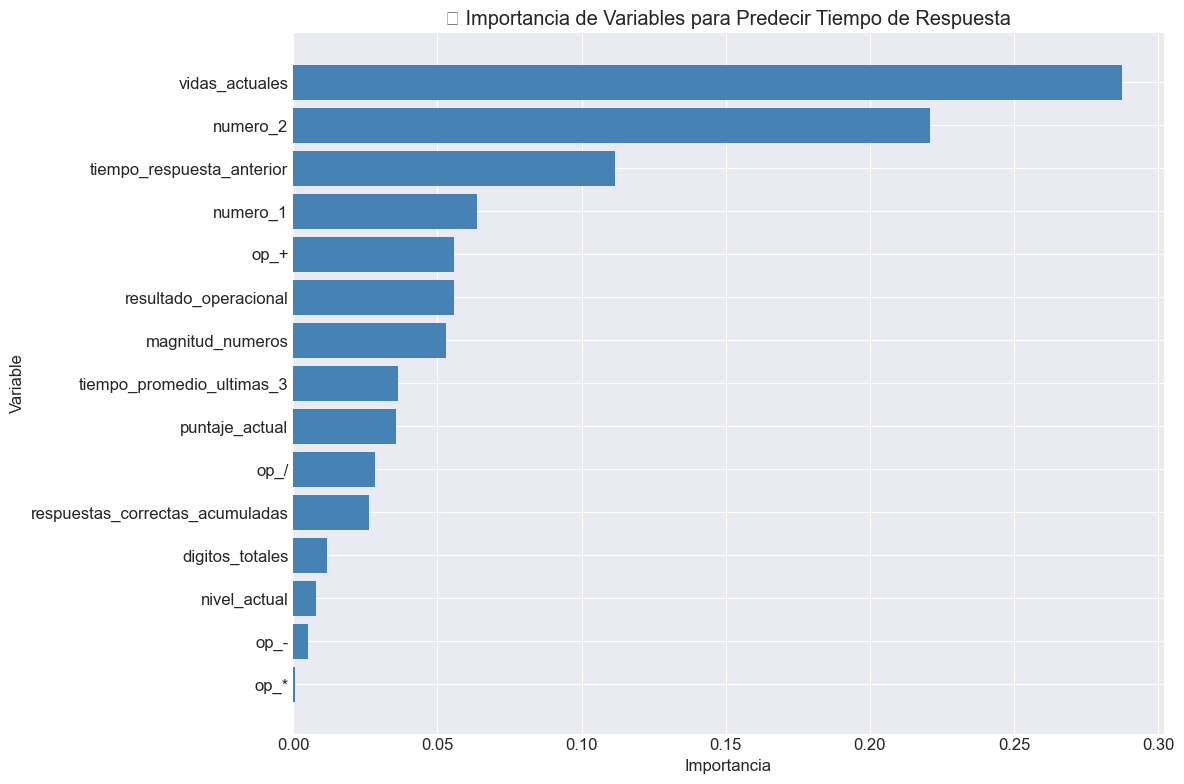


📊 RANKING DE IMPORTANCIA DE VARIABLES:
vidas_actuales                       28.7% ██████████████
numero_2                             22.1% ███████████
tiempo_respuesta_anterior            11.2% █████
numero_1                              6.4% ███
op_+                                  5.6% ██
resultado_operacional                 5.6% ██
magnitud_numeros                      5.3% ██
tiempo_promedio_ultimas_3             3.6% █
puntaje_actual                        3.6% █
op_/                                  2.8% █
respuestas_correctas_acumuladas       2.6% █
digitos_totales                       1.2% 
nivel_actual                          0.8% 
op_-                                  0.5% 
op_*                                  0.1% 


In [20]:
# Importancia de features (usando Random Forest)
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualizar
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('🎯 Importancia de Variables para Predecir Tiempo de Respuesta')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n📊 RANKING DE IMPORTANCIA DE VARIABLES:")
print("="*50)
for i, row in feature_importance.iterrows():
    pct = row['Importance'] * 100
    bar = '█' * int(pct / 2)
    print(f"{row['Feature']:35} {pct:5.1f}% {bar}")

## 11. Conclusiones y Recomendaciones

### 📌 Variables MÁS IMPORTANTES para predecir el tiempo:

1. **`tiempo_respuesta_anterior`** ⭐⭐⭐
   - El tiempo de la pregunta anterior es el mejor predictor
   - Si el usuario fue lento → probablemente será lento de nuevo
   - Si fue rápido → probablemente seguirá siendo rápido

2. **`tiempo_promedio_ultimas_3`** ⭐⭐⭐
   - Promedio de las últimas 3 respuestas
   - Suaviza variaciones de una sola pregunta

3. **`signo_operacional`** ⭐⭐
   - División y multiplicación toman más tiempo que suma/resta

4. **`magnitud_numeros` / `digitos_totales`** ⭐⭐
   - Números más grandes = más tiempo de procesamiento

5. **`nivel_actual`** ⭐
   - Indica la dificultad general del juego

### 🎮 Recomendación para el Modo Infinito:

```python
# Fórmula sugerida para calcular el tiempo de la siguiente pregunta:
tiempo_siguiente = tiempo_base * factor_operacion * factor_complejidad

# Donde:
# - tiempo_base = promedio de las últimas 3 respuestas del usuario
# - factor_operacion = {'+': 0.8, '-': 0.9, '*': 1.1, '/': 1.2}
# - factor_complejidad = 1 + (digitos_totales - 2) * 0.1
```

In [21]:
# Implementación de ejemplo del algoritmo adaptativo
print("\n" + "="*70)
print("🎮 IMPLEMENTACIÓN SUGERIDA PARA EL MODO INFINITO")
print("="*70)

def calcular_tiempo_adaptativo(tiempos_anteriores, operacion, num1, num2, tiempo_minimo=5, tiempo_maximo=15):
    """
    Calcula el tiempo adaptativo para la siguiente pregunta.
    
    Args:
        tiempos_anteriores: Lista de tiempos de las últimas respuestas
        operacion: Tipo de operación (+, -, *, /)
        num1, num2: Números del problema
        tiempo_minimo: Tiempo mínimo permitido
        tiempo_maximo: Tiempo máximo permitido
    
    Returns:
        Tiempo recomendado para la siguiente pregunta
    """
    # Factor base: promedio de las últimas respuestas
    if tiempos_anteriores:
        tiempo_base = np.mean(tiempos_anteriores[-3:])  # Últimas 3
    else:
        tiempo_base = 10.0  # Valor por defecto
    
    # Factor por tipo de operación
    factores_operacion = {
        '+': 0.8,   # Suma es más fácil
        '-': 0.9,   # Resta es relativamente fácil
        '*': 1.1,   # Multiplicación requiere más tiempo
        '/': 1.2    # División es más difícil
    }
    factor_op = factores_operacion.get(operacion, 1.0)
    
    # Factor por complejidad de números
    digitos = len(str(num1)) + len(str(num2))
    factor_complejidad = 1 + (digitos - 2) * 0.1
    
    # Calcular tiempo
    tiempo = tiempo_base * factor_op * factor_complejidad
    
    # Aplicar límites
    tiempo = max(tiempo_minimo, min(tiempo_maximo, tiempo))
    
    return round(tiempo, 1)

# Ejemplo de uso
print("\n📝 Ejemplo de uso:")
print("-" * 50)

# Simular una sesión
tiempos_sesion = [3.5, 2.8, 4.2]  # Últimos tiempos del usuario

ejemplos = [
    ('+', 5, 3),
    ('*', 7, 8),
    ('/', 56, 7),
    ('-', 45, 23),
]

for op, n1, n2 in ejemplos:
    tiempo_sugerido = calcular_tiempo_adaptativo(tiempos_sesion, op, n1, n2)
    print(f"   Problema: {n1} {op} {n2} → Tiempo sugerido: {tiempo_sugerido}s")


🎮 IMPLEMENTACIÓN SUGERIDA PARA EL MODO INFINITO

📝 Ejemplo de uso:
--------------------------------------------------
   Problema: 5 + 3 → Tiempo sugerido: 5s
   Problema: 7 * 8 → Tiempo sugerido: 5s
   Problema: 56 / 7 → Tiempo sugerido: 5s
   Problema: 45 - 23 → Tiempo sugerido: 5s


## ✅ Conclusión Final

Las **variables del JSON SÍ son útiles** para crear un modelo de predicción de tiempo. Las más importantes son:

| Variable | Utilidad | Razón |
|----------|----------|-------|
| `tiempo_respuesta_anterior` | ⭐⭐⭐ ALTA | Mejor predictor del comportamiento del usuario |
| `signo_operacional` | ⭐⭐ MEDIA | Diferentes operaciones tienen diferente dificultad |
| `numero_1`, `numero_2` | ⭐⭐ MEDIA | Números más grandes = más tiempo |
| `nivel_actual` | ⭐ BAJA | Correlación indirecta con dificultad |
| `respuestas_correctas_acumuladas` | ⭐ BAJA | Indica experiencia del jugador |

### Recomendación:
Para el modo infinito, usar el **algoritmo adaptativo** mostrado arriba que combina:
1. Promedio de tiempos recientes del usuario
2. Factor de dificultad por tipo de operación
3. Factor de complejidad por magnitud de números